# Entrainement du modèle d'identification du grade de la route

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. Chargement du dataframe contenant les données d'entrainement

In [2]:
# Téléchargement et extraction des fichiers

!wget -O DataFrameGlobal.zip -q http://62.210.208.36/DataFrameGlobal.zip
!unzip /content/DataFrameGlobal.zip

Archive:  /content/DataFrameGlobal.zip
  inflating: DataFrameGlobal.csv     


In [25]:
# Création du DataFrame
df = pd.read_csv("/content/DataFrameGlobal.csv")

In [26]:
df

,Temps (s),H_v4.2_p1.6,A_v1.5_p1.9,C_v4.6_p1.6,D_v5.3_p2.5,C_v2.3_p2.1,B_v3.2_p2.0,B_v1.6_p2.1,E_v2.7_p2.1,D_v4.5_p1.6,...,E_v3.9_p2.1,C_v2.8_p2.4,D_v2.0_p1.6,A_v4.8_p1.7,A_v2.0_p1.8,B_v2.1_p2.1,C_v3.9_p1.5,H_v2.4_p2.4,D_v2.8_p1.5,E_v3.0_p2.4
0,0.01,9.820949,9.810012,9.810309,9.810864,9.810066,9.810066,9.810021,9.810502,9.810559,...,9.811074,9.810096,9.810128,9.810055,9.810013,9.810038,9.810281,9.815779,9.810251,9.810619
1,0.02,9.820924,9.810012,9.810309,9.810861,9.810066,9.810066,9.810021,9.810501,9.810557,...,9.811072,9.810096,9.810128,9.810055,9.810013,9.810038,9.810280,9.815772,9.810251,9.810618
2,0.03,9.820905,9.810012,9.810308,9.810859,9.810066,9.810066,9.810021,9.810501,9.810556,...,9.811070,9.810096,9.810128,9.810055,9.810013,9.810038,9.810280,9.815766,9.810251,9.810617
3,0.04,9.820876,9.810012,9.810307,9.810856,9.810066,9.810066,9.810021,9.810500,9.810555,...,9.811067,9.810096,9.810128,9.810055,9.810013,9.810038,9.810279,9.815757,9.810250,9.810616
4,0.05,9.820848,9.810012,9.810306,9.810854,9.810066,9.810065,9.810021,9.810499,9.810553,...,9.811065,9.810096,9.810128,9.810055,9.810013,9.810038,9.810279,9.815748,9.810250,9.810615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,59.96,9.749314,9.809909,9.809312,9.811260,9.809851,9.809835,9.809971,9.795675,9.807858,...,9.805110,9.862128,9.809256,9.809682,9.809924,9.809719,9.808720,9.765516,9.949141,11.898909
5996,59.97,9.749486,9.809909,9.809315,9.811256,9.809851,9.812324,9.809971,9.807878,9.807865,...,9.805123,9.809189,9.809256,9.809683,9.809924,9.809720,9.808724,9.765512,9.807884,9.803014
5997,59.98,9.749638,9.809909,9.809316,9.811252,9.809851,9.809683,9.809971,9.807876,9.807871,...,9.124485,9.809192,9.809257,9.809684,9.809924,9.809720,9.477516,9.765571,9.807891,9.802970
5998,59.99,12.087333,9.809909,9.809319,9.811248,9.809852,9.809684,9.809971,9.807881,9.807877,...,9.806304,9.809193,9.809258,9.809685,9.809924,9.809721,9.809038,9.765639,9.807894,9.802984


Normalisation des données :

In [27]:
from sklearn import preprocessing

x = df.iloc[:,1:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df.iloc[:,1:] = pd.DataFrame(x_scaled)

In [28]:
df

,Temps (s),H_v4.2_p1.6,A_v1.5_p1.9,C_v4.6_p1.6,D_v5.3_p2.5,C_v2.3_p2.1,B_v3.2_p2.0,B_v1.6_p2.1,E_v2.7_p2.1,D_v4.5_p1.6,...,E_v3.9_p2.1,C_v2.8_p2.4,D_v2.0_p1.6,A_v4.8_p1.7,A_v2.0_p1.8,B_v2.1_p2.1,C_v3.9_p1.5,H_v2.4_p2.4,D_v2.8_p1.5,E_v3.0_p2.4
0,0.01,0.511442,0.528796,0.557898,0.536754,0.531096,0.528506,0.528795,0.528382,0.737537,...,0.637528,0.559117,0.528633,0.496499,0.528639,0.528810,0.579441,0.527342,0.530701,0.600517
1,0.02,0.511441,0.528796,0.557898,0.536754,0.531096,0.528506,0.528794,0.528382,0.737537,...,0.637528,0.559117,0.528633,0.496499,0.528639,0.528810,0.579441,0.527342,0.530701,0.600517
2,0.03,0.511441,0.528796,0.557898,0.536754,0.531096,0.528506,0.528794,0.528381,0.737537,...,0.637528,0.559117,0.528633,0.496499,0.528639,0.528810,0.579441,0.527342,0.530701,0.600517
3,0.04,0.511441,0.528796,0.557898,0.536754,0.531096,0.528506,0.528794,0.528381,0.737537,...,0.637528,0.559117,0.528633,0.496499,0.528639,0.528810,0.579441,0.527342,0.530701,0.600517
4,0.05,0.511441,0.528796,0.557897,0.536754,0.531096,0.528506,0.528794,0.528381,0.737537,...,0.637528,0.559117,0.528633,0.496498,0.528639,0.528810,0.579441,0.527342,0.530701,0.600517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,59.96,0.510906,0.528595,0.557640,0.536785,0.530969,0.528325,0.528733,0.527096,0.737313,...,0.637419,0.586445,0.528416,0.496065,0.528421,0.528528,0.579352,0.526799,0.557238,0.737767
5996,59.97,0.510908,0.528595,0.557641,0.536784,0.530969,0.530276,0.528733,0.528154,0.737313,...,0.637419,0.558640,0.528416,0.496066,0.528422,0.528528,0.579352,0.526799,0.530249,0.600017
5997,59.98,0.510909,0.528595,0.557641,0.536784,0.530970,0.528206,0.528733,0.528154,0.737314,...,0.624938,0.558642,0.528416,0.496068,0.528422,0.528529,0.560389,0.526800,0.530250,0.600014
5998,59.99,0.528375,0.528595,0.557642,0.536784,0.530970,0.528207,0.528733,0.528154,0.737314,...,0.637440,0.558642,0.528416,0.496069,0.528422,0.528529,0.579370,0.526800,0.530251,0.600015


Affichage de quelques séries :

In [29]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df),len(df)+1),y=df[df.columns[1]], line=dict(color='blue', width=1),name=df.columns[1]))
fig.add_trace(go.Scatter(x=np.linspace(0,len(df),len(df)+1),y=df[df.columns[2]], line=dict(color='red', width=1),name=df.columns[2]))
fig.add_trace(go.Scatter(x=np.linspace(0,len(df),len(df)+1),y=df[df.columns[3]], line=dict(color='black', width=1),name=df.columns[3]))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

### 2. Création du dataset d'entrainement et de test

**2.1. Création des datasets global (avec les données d'entrainement et de test)**

Le dataset d'entrainement contient des milliers de séquences de 30 secondes, chacune étant identifiée comme appartenant à un grade spécifique de la route (A,B,C,D,E,F,G ou H) : 

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/VibrationRoute/Extraction10s.jpg?raw=true" width=800></center>

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/raw/main/VibrationRoute/GradesRoutes.jpg" width=600></center>

Pour coder les labels, on utilise le format one_hot avec la fonction [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical):

In [30]:
from keras.utils import to_categorical

grades = [0,1,2,3,4,5,6,7]

codes_one_hot = to_categorical(grades)
print(codes_one_hot)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


La structure du dataset est la suivante :

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/VibrationRoute/ContenuDataset4.png?raw=true" width=1024></center>

In [31]:
# Extraction des quantités annexes à partir des données d'accélération
def get_annexes(serie):
  # Variance
  variance = tf.math.reduce_variance(serie)
  # Ecart type
  std = tf.math.reduce_std(serie)
  # max
  max = tf.math.reduce_max(serie)
  # min
  min = tf.math.reduce_min(serie)

  return tf.convert_to_tensor([variance, std, max, min], dtype=tf.float32)

In [32]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...X300), Y, Z
# X sont les échantillons aux pas de 0.1s (100 échantillons = 10 secondes)
# Y sont les entrées annexes (vitesse et quantités extraites des données d'accélération)
# Z sont les labels (grades de la route) au format one_hot : A=0, B=1, ..., H=7

def prepare_dataset_XY(serie, label, vitesse, taille_fenetre, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre, shift=taille_fenetre, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre))
  dataset = dataset.map(lambda x: (x, tf.concat([vitesse,get_annexes(x)],0), codes_one_hot[label]))
  return dataset

In [33]:
def get_label(grade_route):
    if grade_route == 'A':
      label = 0
    elif grade_route == 'B':
      label = 1
    elif grade_route == 'C':
      label = 2
    elif grade_route == 'D':
      label = 3
    elif grade_route == 'E':
      label = 4
    elif grade_route == 'F':
      label = 5
    elif grade_route == 'G':
      label = 6
    elif grade_route == 'H':
      label = 7
    return tf.convert_to_tensor(label)

In [ ]:
taille_fenetre = 100*10
batch_size = 16
ratio_entrainement = 0.8

# Création du dataset initial
serie = df[df.columns[1]].values

grade_route = df.columns[1].split("_")[0]
vitesse = tf.convert_to_tensor([float(df.columns[1].split("_")[1].split("v")[1])])
label = get_label(grade_route)
dataset = prepare_dataset_XY(serie,label,vitesse, taille_fenetre,10000)

# Concaténation avec les datasets suivants
from tqdm import tqdm
for i in tqdm(range(len(df.columns))):
  colonne = df.columns[i]
  if i > 1:
    # Extraction des labels
    grade_route = colonne.split("_")[0]
    vitesse = tf.convert_to_tensor([float(colonne.split("_")[1].split("v")[1])])
    label = get_label(grade_route)
    
    # Création de la série
    serie = df[colonne].values

    # Création du dataset
    dataset_ = prepare_dataset_XY(serie,label,vitesse,taille_fenetre,10000)
    dataset = dataset.concatenate(dataset_)

# Création des batchs
dataset = dataset.batch(batch_size,drop_remainder=True)

  2%|▏         | 53/3072 [00:05<07:58,  6.31it/s]

**2.2. Séparation des données d'entrainement et de tests**

Format des dataset : [(serie,annexes,label), ...]

In [ ]:
ratio_entrainement = 0.8
dataset_ent, dataset_test = tf.keras.utils.split_dataset(dataset, left_size=ratio_entrainement)

**2.3. Réorganisation des datasets**

Format final des dataset : [((serie,annexes),label), ...]

In [ ]:
dataset_ent = dataset_ent.map(lambda x,y,z : ((x,y),z))
dataset_test = dataset_test.map(lambda x,y,z : ((x,y),z))

In [ ]:
i = 0
for element in dataset_ent:
  i=i+1
  if i > 1:
    break
  print(element)

### 3. Mise en place du modèle

Principe de l'utilisation des réseaux de convolution sur la série temporelle :

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/VibrationRoute/schema_base.png?raw=true" width=600></center>

**3.1. Création du modèle à base de réseaux de convolution**

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/VibrationRoute/structure_reseau.png?raw=true" width=600></center>

In [ ]:
from keras.layers.merging.concatenate import concatenate

entree_serie = tf.keras.layers.Input(shape=(taille_fenetre), name="First")
entree_annexes = tf.keras.layers.Input(shape=(5), name="Second")

# Réseau de convolution
conv1 = keras.layers.Conv1D(filters=8, kernel_size=7, padding="same")(tf.expand_dims(entree_serie,axis=-1))
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)
conv1 = keras.layers.Dropout(0.2)(conv1)
conv1 = keras.layers.MaxPool1D()(conv1)

conv2 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)
conv2 = keras.layers.Dropout(0.1)(conv2)

conv3 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)

conv4 = keras.layers.Add()([conv1,conv3])
conv4 = keras.layers.ReLU()(conv4)
conv4 = keras.layers.Dropout(0.2)(conv4)
conv4 = keras.layers.MaxPool1D()(conv4)
conv4 = keras.layers.Flatten()(conv4)

# Prise en compte des entrées annexes
concat = keras.layers.concatenate([conv4,entree_annexes])

# Construction du modèle
output_layer = keras.layers.Dense(8, activation="softmax")(concat)


model = tf.keras.Model(inputs=[entree_serie,entree_annexes],outputs=output_layer)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 First (InputLayer)             [(None, 1000)]       0           []                               
                                                                                                  
 tf.expand_dims_11 (TFOpLambda)  (None, 1000, 1)     0           ['First[0][0]']                  
                                                                                                  
 conv1d_33 (Conv1D)             (None, 1000, 8)      64          ['tf.expand_dims_11[0][0]']      
                                                                                                  
 batch_normalization_33 (BatchN  (None, 1000, 8)     32          ['conv1d_33[0][0]']              
 ormalization)                                                                             

**3.2. Définition de l'optimiseur et de la fonction d'erreur**

On utilise l'optimiseur Adam ainsi qu'une fonction d'erreur de type [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class).

L'ensemble des fonctions d'erreur utilisables avec Keras se trouve ici : https://keras.io/api/losses/

La fonction d'erreur que nous utilisons permet de gérer les labels multiples qui ont été codés en représentation "one_hot".

In [ ]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile le modèle
model.compile(loss="categorical_crossentropy", optimizer=optimiseur, metrics=['accuracy'])

**3.3. Entrainement du modèle**

In [ ]:
historique = model.fit(dataset_ent, validation_data = dataset_test, epochs=30, batch_size=batch_size)

Epoch 1/30
1843/1843 [==============================] - 33s 17ms/step - loss: 1.6719 - accuracy: 0.4192 - val_loss: 1.4940 - val_accuracy: 0.3761
Epoch 2/30
1843/1843 [==============================] - 31s 17ms/step - loss: 1.1780 - accuracy: 0.5449 - val_loss: 1.3307 - val_accuracy: 0.4657
Epoch 3/30
1843/1843 [==============================] - 32s 17ms/step - loss: 1.0426 - accuracy: 0.6032 - val_loss: 1.2649 - val_accuracy: 0.3981
Epoch 4/30
1843/1843 [==============================] - 30s 16ms/step - loss: 0.9397 - accuracy: 0.6441 - val_loss: 1.2559 - val_accuracy: 0.4171
Epoch 5/30
1843/1843 [==============================] - 30s 16ms/step - loss: 0.8645 - accuracy: 0.6739 - val_loss: 1.3046 - val_accuracy: 0.4065
Epoch 6/30
1843/1843 [==============================] - 30s 16ms/step - loss: 0.7949 - accuracy: 0.7037 - val_loss: 1.2085 - val_accuracy: 0.4784
Epoch 7/30
1843/1843 [==============================] - 32s 17ms/step - loss: 0.7588 - accuracy: 0.7112 - val_loss: 1.1915 -

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Evolution de la précision en fonction de la période')

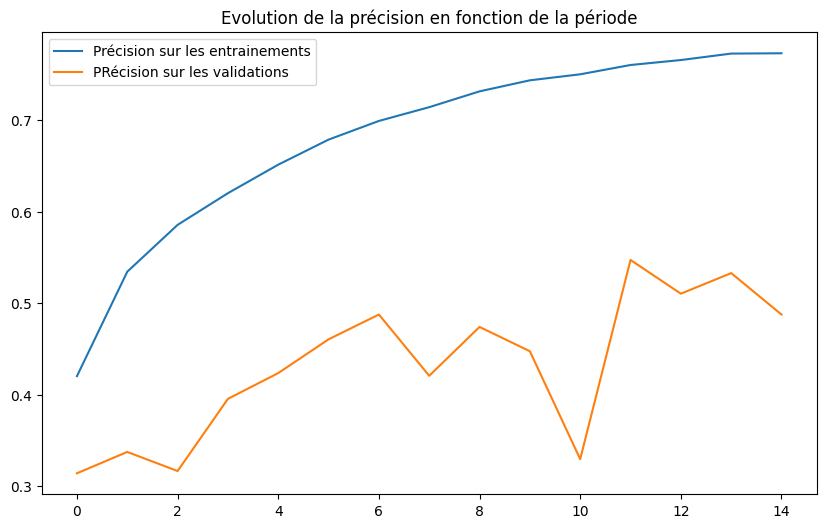

In [ ]:
erreur_entrainement = historique.history["accuracy"]
erreur_validation = historique.history["val_accuracy"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Précision sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="PRécision sur les validations")
plt.legend()

plt.title("Evolution de la précision en fonction de la période")

**3.4. Évaluation du modèle**

In [ ]:
model.evaluate(dataset_test)

### 4. Sauvegarde du modèle au format ONNX